<a href="https://colab.research.google.com/github/KovvadaHaritha/PORTFOLIO/blob/master/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-13 12:19:07--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.112, 18.160.200.126, 18.160.200.77, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   209MB/s    in 0.2s    

2024-05-13 12:19:08 (209 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


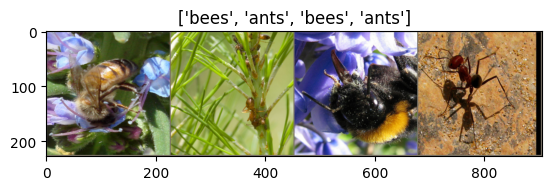

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


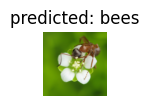

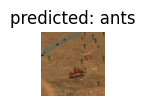

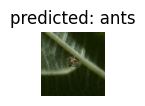

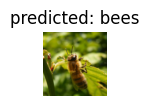

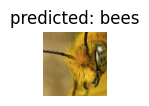

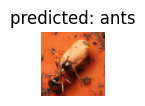

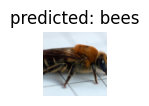

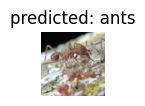

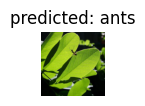

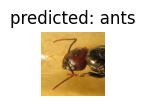

In [11]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

1answer:
Data augmentations like resizing, cropping, flipping, rotating, etc., are essential techniques used during the training of machine learning models, especially in computer vision tasks. They offer several key benefits:

Increased Robustness: Augmentations introduce variations in the training data, which helps the model become more robust to changes in input during inference. For example, resizing images to different dimensions allows the model to learn to recognize objects at various scales.

Improved Generalization: By presenting the model with diverse variations of the training data, augmentations help prevent overfitting and improve the model's ability to generalize to unseen data. This is particularly important when the training dataset is limited.

Regularization: Augmentations act as a form of regularization by adding noise to the training data, which helps prevent the model from memorizing the training examples and encourages it to learn more meaningful features.

Data Balancing: Augmentations can help balance the distribution of classes in the training dataset. For example, by applying random rotations or flips, you can generate new samples for underrepresented classes, which can improve the model's performance on those classes.

Increased Variability: Augmentations increase the variability of the training data, making it more representative of the real-world scenarios the model may encounter during inference. This helps the model learn to adapt to different conditions and variations in the input data.

Overall, the significance of using data augmentations lies in their ability to improve the robustness, generalization, and performance of machine learning models by enriching the training dataset with diverse variations of the original data.

2 answer
If you don't use a pre-trained ResNet model and instead train the model from scratch (pretrained=False), the performance may vary depending on factors such as the dataset size, complexity, and the specific problem you're working on.

Training a deep neural network like ResNet from scratch requires a large amount of labeled data and computational resources, as well as careful tuning of hyperparameters. Without the benefit of pre-trained weights, the model starts with randomly initialized weights and needs to learn meaningful representations directly from the data during training.

In general, training a deep neural network from scratch is more challenging and may require longer training times compared to fine-tuning a pre-trained model. Additionally, the model's performance may not reach the same level of accuracy achieved when using a pre-trained model, especially if the dataset is small or the task is complex.

To evaluate the performance of the model trained without pre-training, you would typically train the model on your dataset and then evaluate its performance on a separate validation or test dataset using appropriate evaluation metrics for your specific task, such as accuracy, precision, recall, F1-score, etc.




## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


3 answer:
The performance of a pre-trained ResNet model on a dataset significantly different from the one it was originally trained on (such as ants vs. bees data) depends on several factors:

Domain Similarity: If the new dataset is from a domain that is significantly different from the original dataset used to pre-train the ResNet model, the performance may be affected. Pre-trained models tend to generalize well to domains similar to the one they were trained on. If the new dataset is too dissimilar (e.g., medical images vs. natural images), the features learned by the pre-trained model may not be relevant for the new task, and performance may suffer.

Transferability of Features: However, even if the new dataset is different, the features learned by the pre-trained model may still be useful for the new task, especially for lower-level features such as edges, textures, and colors. In many cases, features learned by pre-trained models on large-scale datasets (like ImageNet) capture general visual concepts that are transferable across different tasks and domains.

Fine-tuning: Fine-tuning the pre-trained model on the new dataset can help adapt the learned features to the specifics of the new task and dataset. By adjusting the model's parameters during fine-tuning, you allow it to learn task-specific features while still benefiting from the general features learned during pre-training.

Data Size: The size and diversity of the new dataset also play a crucial role. If the new dataset is small, fine-tuning the entire model may lead to overfitting. In such cases, techniques like transfer learning with feature extraction (freezing most of the pre-trained layers and only fine-tuning the final layers) or data augmentation can be beneficial.

In summary, while using a pre-trained ResNet model on a significantly different dataset may still provide a good starting point, fine-tuning and careful evaluation are necessary to achieve optimal performance on the new task.





